# 0. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import seaborn as sns
from imblearn.over_sampling import SMOTE
import time
import gc
import joblib

# 1. Constants & functions

In [2]:
random_state = 42
test_size = 0.2
search_type = "grid_search" # Choose between random_search (faster) or grid_search (exhaustive, more expensive)

In [3]:
def evaluate_model(model, X_test, y_test, le):
    """
    Evaluates the performance of a machine learning model on test data.

    Parameters:
    - model: The trained machine learning model.
    - X_test: The feature matrix of the test data.
    - y_test: The target labels of the test data.

    Returns:
    - df: A pandas DataFrame containing the evaluation metrics for each class and the weighted average.
    """
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, average=None, labels=le.transform(le.classes_))
    precision = precision_score(y_test, predictions, average=None, labels=le.transform(le.classes_))                   
    recall = recall_score(y_test, predictions, average=None, labels=le.transform(le.classes_))
    labels=le.classes_
    df = pd.DataFrame([
        dict(Class=labels[i],
            Precision=precision[i],
            Recall=recall[i],
            F1=f1[i],
            ) for i in range(len(labels))
            ])

    d = {
        "Class": "Weighted Average",
        "Precision": precision_score(y_test, predictions, average="weighted"),
        "Recall": recall_score(y_test, predictions, average="weighted"),
        "F1": f1_score(y_test, predictions, average="weighted"),
        }
    df = pd.concat([df, pd.DataFrame([d])], ignore_index=True)    
    df[["Precision", "Recall", "F1"]] = df[["Precision", "Recall", "F1"]].round(3)

    return df.set_index("Class")

def call_classifier(df, random_state, test_size, search_type, experiment_identifier, oversampling_smote, class_weight):
    # Define features and targets
    X = df.drop(['Class'], axis=1)
    le = LabelEncoder()
    y = le.fit_transform(df["Class"])
    # Split the train and test sets. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    if oversampling_smote:
        smote = SMOTE(random_state=random_state)
        # Apply SMOTE only over the train data
        X_train, y_train = smote.fit_resample(X_train, y_train)
    param_grid = {
    "clf__n_estimators": [5, 10, 50, 100, 200],
    "clf__max_depth": [None, 5, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_features": [None, "sqrt", "log2"], 
    }
    scoring = "f1_weighted"
    # Plot histogram of training dataset
    print("Histogram of training dataset:")
    labels, counts = np.unique(y_train,return_counts=True)
    ticks = range(len(counts))
    plt.bar(ticks,counts, align='center',facecolor='silver', edgecolor='black')
    original_labels = le.inverse_transform(labels) # Convert back the numerical labels to original class names
    plt.xticks(ticks, original_labels)
    plt.tick_params(axis='both', which='major', labelsize=14)
    #plt.savefig('histogram_training_dataset_experiment_{}.png'.format(experiment_identifier), dpi=300)
    plt.savefig('histogram_training_dataset_experiment_{}.pdf'.format(experiment_identifier))
    plt.show()

    pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('clf',  RandomForestClassifier(class_weight = class_weight, random_state=random_state))
    ])
    if search_type == "random_search":
        pipeline = RandomizedSearchCV(pipe, param_grid, n_iter=200, cv=5, n_jobs=-1, verbose=0, scoring=scoring,
                                   random_state=random_state)
    elif search_type == "grid_search":
        pipeline = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=0, scoring=scoring)
    else:
        raise ValueError("search_type not valid")

    # Evaluate model
    pipeline.fit(X_train, y_train)   
    best_model = pipeline.best_estimator_
    evaluation_result = evaluate_model(best_model, X_test, y_test, le) 
    predictions = best_model.predict(X_test)
    print(evaluation_result, "\nAccuracy: {}".format(round(accuracy_score(y_test, predictions), 3)))

    #Save label encoder and classifier for future applications
    joblib.dump(le, 'label_encoder_experiment_{}.pkl'.format(experiment_identifier)) 
    joblib.dump(best_model, 'classifier_experiment_{}.pkl'.format(experiment_identifier)) 

    # Plot confusion matrix
    cm = confusion_matrix(y_test, predictions, labels=le.transform(le.classes_))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greys", cbar=False, annot_kws={"size": 14})
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], le.classes_, fontsize=14)
    plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], le.classes_, fontsize=14)
    plt.tight_layout()
    #plt.savefig('ConfusionMatrix_RandomForest_{}.png'.format(experiment_identifier), dpi=300)
    plt.savefig('ConfusionMatrix_RandomForest_{}.pdf'.format(experiment_identifier))
    plt.show()
    
    return

# 2. Read data

In [4]:
df_HMXB = pd.read_csv("HMXB.csv", sep=',', comment='#')
df_LMXB = pd.read_csv("LMXB.csv", sep=',', comment='#')
df_extragalactic_large_accretors = pd.read_csv("AGN.csv", sep=',', comment='#')
# Add labels before merging
df_HMXB['Class'] = 'HMXB'
df_LMXB['Class'] = 'LMXB'
df = pd.concat([df_HMXB, df_LMXB, df_extragalactic_large_accretors], ignore_index=True)
df['Class'] = df['Class'].str.strip()
# New features defined by Perez-Díaz+2024
df['var_ratio_b'] = df['var_mean_b'] / df['var_sigma_b']
df['var_ratio_h'] = df['var_mean_h'] / df['var_sigma_h']
df['var_ratio_s'] = df['var_mean_s'] / df['var_sigma_s']
df['var_newq_b'] = (df['var_max_b'] + df['var_min_b']) / (2 * df['var_mean_b'])

# Perez-Díaz+2024 feature selection
df = df[['hard_hm', 'hard_hs', 'hard_ms', 'bb_kt', 'powlaw_gamma', 'var_prob_b', 
         'var_prob_h', 'var_prob_s', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 
         'var_newq_b', 'Class']]
# Some values of sigma are zero, and Perez-Díaz+2024 cleans NaNs:
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)].dropna()

del df_HMXB, df_LMXB, df_extragalactic_large_accretors
gc.collect()

23

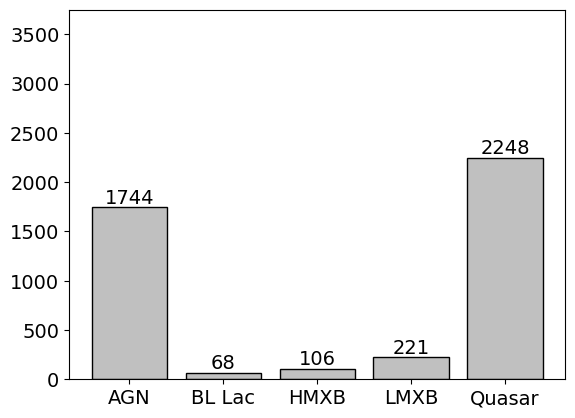

In [5]:
labels, counts = np.unique(df['Class'],return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center',facecolor='silver', edgecolor='black')
plt.xticks(ticks, labels)
plt.ylim(0,3750)
# Add numbers above each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('histogram_nofilter.png', dpi=300)
plt.savefig('histogram_nofilter.pdf')
plt.show()

# 3. Experiments

## 3.1 Experiment 1

Random undersampling of quasars and AGNs choosing as an arbitrary threshold once the available amount of LMXB, without class weighting.

In [6]:
threshold = len(df[df['Class'] == 'LMXB'])

df_aux_AGN = resample(df[df['Class'] == 'AGN'], replace=False, n_samples = threshold, random_state = random_state)
df_aux_Quasar = resample(df[df['Class'] == 'Quasar'], replace=False, n_samples = threshold, random_state = random_state)
df1 = pd.concat([df[df['Class'] == 'HMXB'], df[df['Class'] == 'LMXB'], df[df['Class'] == 'BL Lac'], df_aux_AGN, df_aux_Quasar], ignore_index=True)

del df_aux_AGN, df_aux_Quasar
gc.collect()

3660

Histogram of training dataset:


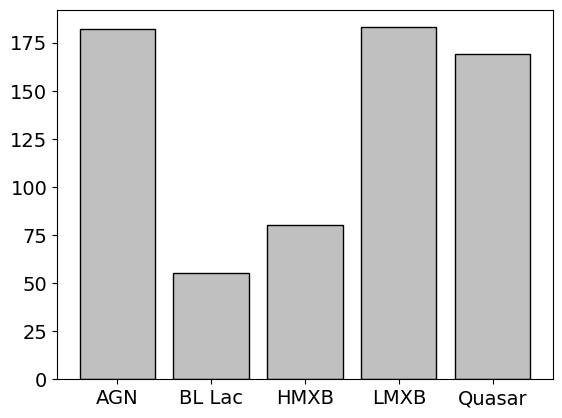

                  Precision  Recall     F1
Class                                     
AGN                   0.347   0.436  0.386
BL Lac                0.500   0.154  0.235
HMXB                  0.824   0.538  0.651
LMXB                  0.789   0.789  0.789
Quasar                0.617   0.712  0.661
Weighted Average      0.616   0.595  0.592 
Accuracy: 0.595


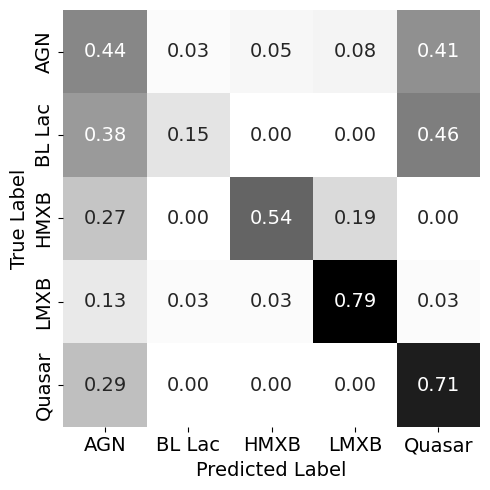

In [7]:
experiment_identifier = "1"
oversampling_smote = False
class_weight = None
call_classifier(df1, random_state, test_size, search_type, experiment_identifier, oversampling_smote, class_weight)

In [8]:
del df1
gc.collect()

17326

## For experiments 2 and 3, the input dataframe is the same. Inside the function "call_classifier", SMOTE will be applied for Experiment 3 and all classes will have the same dataset size.

In [9]:
threshold = 2 * len(df[df['Class'] == 'LMXB'])

df_aux_AGN = resample(df[df['Class'] == 'AGN'], replace=False, n_samples = threshold, random_state = random_state)
df_aux_Quasar = resample(df[df['Class'] == 'Quasar'], replace=False, n_samples = threshold, random_state = random_state)
df23 = pd.concat([df[df['Class'] == 'HMXB'], df[df['Class'] == 'LMXB'], df[df['Class'] == 'BL Lac'], df_aux_AGN, df_aux_Quasar], ignore_index=True)

del df_aux_AGN
del df_aux_Quasar

## 3.2 Experiment 2

Random undersampling of quasars and AGNs choosing as an arbitrary threshold twice the available amount of LMXB, with class weighting.

Histogram of training dataset:


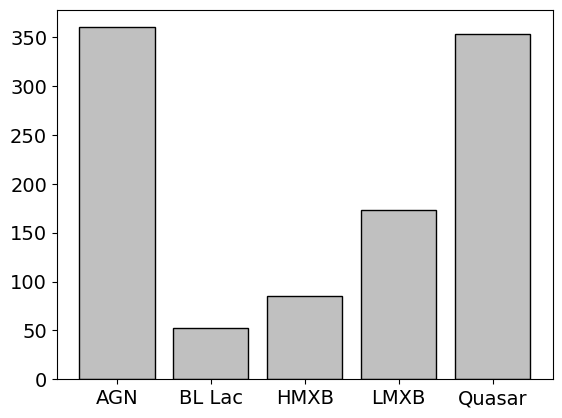

                  Precision  Recall     F1
Class                                     
AGN                   0.569   0.451  0.503
BL Lac                0.333   0.062  0.105
HMXB                  0.542   0.619  0.578
LMXB                  0.841   0.771  0.804
Quasar                0.608   0.820  0.699
Weighted Average      0.617   0.629  0.609 
Accuracy: 0.629


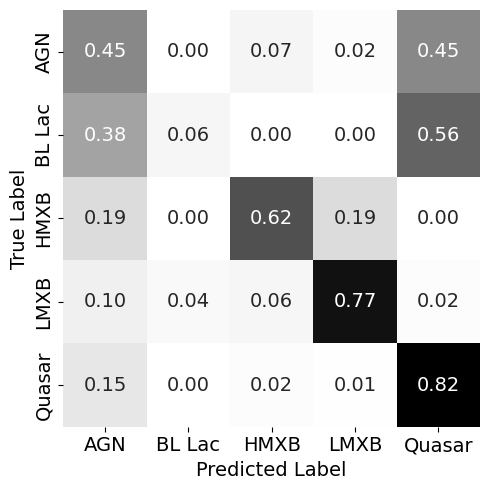

In [10]:
experiment_identifier = "2"
oversampling_smote = False
class_weight = 'balanced_subsample'
call_classifier(df23, random_state, test_size, search_type, experiment_identifier, oversampling_smote, class_weight)

## 3.3 Experiment 3

Oversampling of X-ray binaries and BL Lac sources via SMOTE in combination with random undersampling of quasars and AGNs, choosing as an arbitrary threshold twice the available amount of LMXB. Class weighting here is not necessary, since all classes will have the same amount of instances.

Histogram of training dataset:


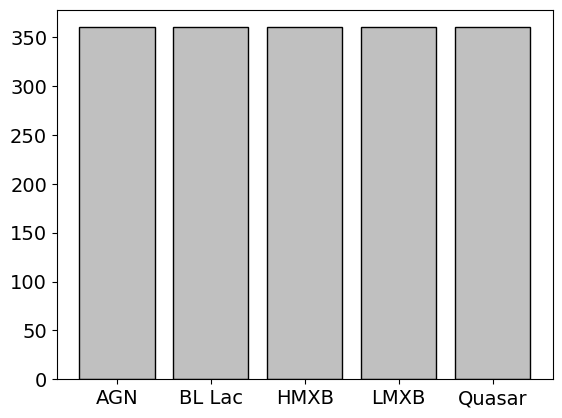

                  Precision  Recall     F1
Class                                     
AGN                   0.540   0.415  0.469
BL Lac                0.179   0.312  0.227
HMXB                  0.552   0.762  0.640
LMXB                  0.844   0.792  0.817
Quasar                0.604   0.618  0.611
Weighted Average      0.598   0.578  0.583 
Accuracy: 0.578


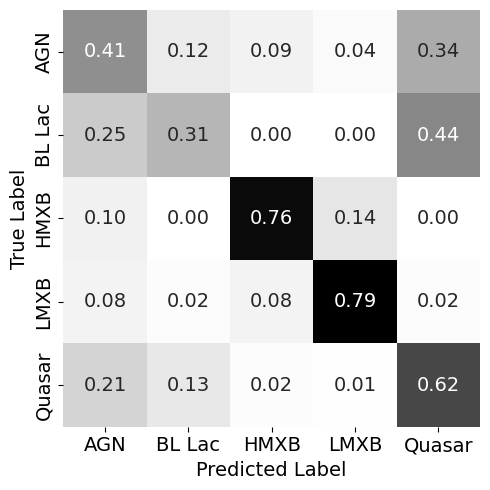

In [11]:
experiment_identifier = "3"
oversampling_smote = True
class_weight = None
call_classifier(df23, random_state, test_size, search_type, experiment_identifier, oversampling_smote, class_weight)

In [12]:
del df23
gc.collect()

5932